In [2]:
#Today we attempt to answer the age-old question: "Should we leave the ball game early?"
#We will break it down statistically and also employ machine learning to arrive at a
#prediction of whether or not it is worth it to stick around.
#First we import the libraries we'll need.
import pandas as pd
from statistics import NormalDist
import random
from statistics import mean
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection  import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import sklearn.metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
import scipy.stats
#and we'll bring in our data.  This is a CSV of all the runs scored in all the games, 
#regular season and playoffs, in the MLB from the years 2010 to 2020.  Thanks to the 
#sports database https://sports-statistics.com for providing these numbers.  They are a GREAT
#resource for sports stats.  This is a list of every game's box score from 2010 to 2020.  It's  
#broken down by inning.
df = pd.read_csv (r"C:\Users\danbr\OneDrive\Documents\Data Science\Runs Data.csv", index_col=None)

In [3]:
#Let's get a look at the data.  It should look like a box score of a ball game, but instead of 2 teams
#there will be over 50,000 (since it is every game for 10 years)
print(df)

       1st  2nd  3rd  4th  5th  6th  7th  8th  9th  Final
0        0    2    0    3    0    0    2    0    0      7
1        0    1    0    0    1    3    3    1    0      9
2        0    0    0    5    0    2    4    0    0     11
3        1    0    0    0    0    0    0    0    0      1
4        0    0    0    0    0    1    0    0    0      1
...    ...  ...  ...  ...  ...  ...  ...  ...  ...    ...
51191    0    0    0    0    1    0    0    0    1      2
51192    1    0    1    0    1    1    2    1    0      7
51193    0    0    0    1    1    3    1    0    2      8
51194    2    1    0    0    1    0    0    0    0      4
51195    0    0    2    0    0    0    0    0    0      2

[51196 rows x 10 columns]


In [4]:
#Looking good.  Let's make sure we're dealing with numbers, while we're at it.
df.dtypes

1st      int64
2nd      int64
3rd      int64
4th      int64
5th      int64
6th      int64
7th      int64
8th      int64
9th      int64
Final    int64
dtype: object

In [5]:
#Looks good!  Let's start to divide these columns up, because the first question I want to look at 
#is: When do runs get scored?  In what inning are the most runs scored.  First I'll copy the table
#onto a new variable.
runs=df

In [6]:
#Now I add up the sum of each column and save it as its own object.
Total_1 = runs["1st"].sum()
Total_2 = runs["2nd"].sum()
Total_3 = runs["3rd"].sum()
Total_4 = runs["4th"].sum()
Total_5 = runs["5th"].sum()
Total_6 = runs["6th"].sum()
Total_7 = runs["7th"].sum()
Total_8 = runs["8th"].sum()
Total_9 = runs["9th"].sum()

In [7]:
#I check a random inning to see if the total has been added up.  23592?  Ok.  Sounds about right.
print(Total_8)

23592


In [8]:
#Now to make an array of run totals, with each inning as its own column.
TotalRuns=np.array([Total_1, Total_2, Total_3, Total_4, Total_5, Total_6, Total_7, Total_8, Total_9])

In [9]:
#How does that look?
print(TotalRuns)

[27572 22825 25685 26272 26266 26445 25024 23592 16872]


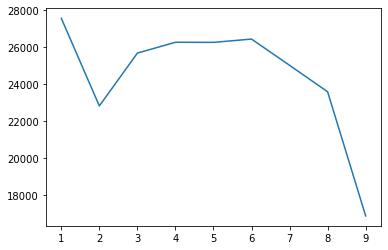

In [10]:
#Perfect!  Now I'm going to plot this out in a line graph.
x=([1,2,3,4,5,6,7,8,9])
y=TotalRuns
plt.plot(x,y)

<function matplotlib.pyplot.show(close=None, block=None)>

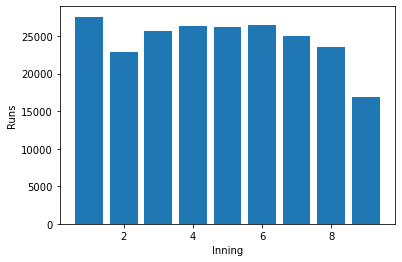

In [11]:
#Woah!!  Runs drop off a cliff in the 9th inning!  Why bother sticking around for that?
#But...look at the y axis.  The lowest number listed is 18,000.  So even though the line in the
#chart looks like it's gone all the way down, that still represents 18,000 runs.  That's not zero.
#So let's change from a line graph to bars:
x=([1,2,3,4,5,6,7,8,9])
y=TotalRuns
plt.bar(x,y)
plt.xlabel('Inning')
plt.ylabel('Runs')
plt.show

In [12]:
#Here we can see that even though, yes, the runs total drops a lot in the 9th, it still has a lot of
#runs in it.  Matter of fact, lets divide the 9th inning total by the total amount of innings in our 
#original chart to get a rough average:
Total_9/51196

0.32955699664036253

In [13]:
#Based on that rough average, you've got a 33% chance of seeing a run in the 9th.
#Let's do the thing for the 8th.
Total_8/51196

0.4608172513477615

In [14]:
#Okay.  46% chance or runs in the 8th.  But this is all very rough.  Let's get more technical.
#I'm going to run a Monte Carlo analysis on this.  First I determine the average and standard
#deviation for runs in the ninth inning:
NinthAvg=runs["9th"].mean()
print(NinthAvg)

0.32955699664036253


In [15]:
NinthSdv=runs["9th"].std()
print(NinthSdv)

0.8217869608472946


In [16]:
#Now I make a function that will simulate a return based on that average and standard deviation.
#We're taking the inverse cdf of a normal distrubution with the average of .32 and st dev of .82.
#The wildcared is the randomized probability.  See, if you put in a 1 for probability (the highest)
#possible probability) you'd get the average value.  But if you put in random probability, this 
#function will return a value somewhere on the probability scale of that avg and st dev.
#One thing I was sure to do was to return 0 if the value was negative.  Cause they can't score 
#negative runs.  No one's that bad. And I set it to only return integers.  No fractional runs.
def SimNine():
    x= NormalDist(mu=0.32, sigma=0.82).inv_cdf(random.uniform(0,1))
    if x>0:
        return int(x)
    else: return 0

In [17]:
#Test out the simulator.  No runs scored.
SimNine()

0

In [18]:
#Well, we have a simulator.  Now to run it 10,000 times to see what we get.  This function is easy.
#It will run through a range of 10,000 iterations of the simulation and add each returned value to a
#list.  It will then take the average value of the contents of that list.  It will give us a value
#of 9th inning runs we should expect based on the stats.
def MonteNine():
    z=[]
    for _  in range(10000):
        z.append(SimNine())
    return int((sum(z)/len(z)))

In [19]:
#Call the Monte Carlo function:
MonteNine()

0

In [20]:
#Goose egg.  Nada.
#Let's do the same thing for the 8th.  Get the avg and std dev:
EighthAvg=runs["8th"].mean()
EighthSdv=runs["8th"].std()
print(EighthAvg)
print(EighthSdv)

0.4608172513477615
0.9893504564804319


In [21]:
#Define the simulator:
def SimEight():
    x= NormalDist(mu=0.46, sigma=0.989).inv_cdf(random.uniform(0,1))
    if x>0:
        return int(x)        
    else: return 0

In [22]:
#test the simulator (ooh, a run!)
SimEight()

1

In [23]:
#Define the Monte Carlo function for the 8th:
def MonteEight():
    z=[]
    for _  in range(10000):
        z.append(SimNine())    
    return int((sum(z)/len(z)))

In [24]:
#Run the Monte Carlo:
MonteEight()

0

In [25]:
#Nohting doing.  But really, we shouldn't be surprised.  In terms of pure statistics, the 50% 
#average threashold would be the total number of rows divided by two:
51196/2

25598.0

In [26]:
#Therefore, any inning run total less than 25,598 is under .500, and the probability favors no runs
#in that inning.
print(TotalRuns)

[27572 22825 25685 26272 26266 26445 25024 23592 16872]


In [27]:
#So, statistically speaking, you're only likely to see scores in the 1st, 3rd, 4th, 
# 5th and 6th innings.  But just because it's less than 50% likely doesn't mean it's 
#not going to happen.  I don't think we should leave it to statistical analysis.  
#Let's build a prediction model.

In [28]:
#I'm making a new table just for predicting runs in the 8th.  We'll ditch the 9th and Final columns.
pred8=runs.drop(["9th","Final"], axis=1)

In [29]:
pred8

,1st,2nd,3rd,4th,5th,6th,7th,8th
0,0,2,0,3,0,0,2,0
1,0,1,0,0,1,3,3,1
2,0,0,0,5,0,2,4,0
3,1,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
51191,0,0,0,0,1,0,0,0
51192,1,0,1,0,1,1,2,1
51193,0,0,0,1,1,3,1,0
51194,2,1,0,0,1,0,0,0


In [30]:
#Now to set up the X and y groups.  X will be the whole table except the 8th inning, and y will be
#the 8th inning (the one we're trying to predict)
X = pred8.drop("8th", axis=1)
X = X.values
y = pred8["8th"]
y = y.values

In [31]:
#Setting up the training and testing data for our machine learning. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

In [32]:
#startint with 5 as the neighbor count:
knn_model = KNeighborsRegressor(n_neighbors=5)

In [33]:
#Time to train the data!  First we'll fit the model:
knn_model.fit(X_train, y_train)

KNeighborsRegressor()

In [34]:
#Calculating the root mean square error.  This is a measurement of the distance between the 
#neighbors in our data.  First we run it for the training data.
train_preds = knn_model.predict(X_train)
mse = mean_squared_error(y_train, train_preds)
rmse = sqrt(mse)
rmse

1.0064597491615317

In [35]:
#Now we'll run that for the testing data:
test_preds = knn_model.predict(X_test)
mse = mean_squared_error(y_test, test_preds)
rmse = sqrt(mse)
rmse

1.0788177122433613

In [36]:
#Those numbers are pretty close.  That indicates that error in the training data model is close to 
#the error in the test data.  Whcih indicates the fit is at least somewhat predictive.  If those 
#values were way different it would indicate our training data doesn't anticipate new data well.
#Now let's figure how many neighbors we should use on our test.
from sklearn.model_selection import GridSearchCV
parameters = {"n_neighbors": range(1, 50)}

In [37]:
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)

In [38]:
gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 50)})

In [39]:
gridsearch.best_params_

{'n_neighbors': 47}

In [40]:
#Okay!  That value for n_neighbors is 47.  So, we should use 47 neighbors to compare our new 
#data points.  Let's introduce a new data point.  We enter in the runs per inning for the first
#seven innings of a ball game:
first7 = np.array([0,0,0,2,0,0,0])

In [41]:
#We define how we measure distances of data for this new data point;
distances= np.linalg.norm(X - first7, axis=1)

In [42]:
#We use 47 for our neighbor count (as established before) and run a k-Nearest Neighbor.
k = 47
nearest_neighbor_ids = distances.argsort()[:k]
nearest_neighbor_ids

array([ 8256,  7877, 23505, 19227,  7096, 35576, 13406,  3114, 15765,
       38212, 10785,  4853, 45117,  6177, 15810, 28927, 11522,   829,
       17281, 13053, 43170,  7765, 49819, 21610,   440, 41547,  3152,
       18686,  4545,  4132,  4134,  7691, 30584, 31874, 50404, 39939,
       48195,   839, 14127, 26399, 22400, 21708, 48993, 45138, 41738,
       12228, 17236], dtype=int64)

In [43]:
#These 47 results are the array IDs for the nearest neighbors or our first 7 innings data point.
#The 8th inning value for each of these are what our model anticiaptes the 8th inning of our
#fist 7 data point would be.  Let's pull the actual values for those array ids:
nearest_neighbor_SP = y[nearest_neighbor_ids]

In [44]:
nearest_neighbor_SP

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       2, 1, 0, 1, 3, 0, 0, 0, 1, 0, 0, 1, 0, 9, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0], dtype=int64)

In [66]:
#Okay!  We might see some action, here.  I'm seeing a bunch of 1's, a 2, a 3.  Is that a 9?!  
#That's a great inning!  But there are a lot of zeroes too.  Let's average it out.
#Wait.  Hold up.  We can't take the average, cause these multi-run innings will through that off.
#If you have 8 zero run innings and toss in that one 9 run inning, the average is 1 run per inning.
#We should count up all the zero-run innings.
NoRuns8 = (nearest_neighbor_SP == 0).sum()

In [67]:
print(NoRuns8)

33


In [47]:
#33 zero run innings our of 47.  So your chance of seeing runs in the eighth?  
1-(33/47)

0.2978723404255319

In [48]:
#Just about thirty percent, based on the First 7 data we used.  Let's do all the same stuff but 
#for the ninth inning this time.
pred9=runs.drop("Final", axis=1)

In [49]:
X1 = pred9.drop("9th", axis=1)
X1 = X1.values
y1 = pred9["9th"]
y1 = y1.values

In [50]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=12345)

In [51]:
knn_model1 = KNeighborsRegressor(n_neighbors=5)

In [52]:
knn_model1.fit(X1_train, y1_train)

KNeighborsRegressor()

In [53]:
train_preds1 = knn_model1.predict(X1_train)
mse1 = mean_squared_error(y1_train, train_preds1)
rmse1 = sqrt(mse1)
rmse1

0.861152229526351

In [54]:
test_preds1 = knn_model1.predict(X1_test)
mse1 = mean_squared_error(y1_test, test_preds1)
rmse1 = sqrt(mse1)
rmse1

0.9040058420718308

In [55]:
#Ooh!  Our root mean square error is looking tight, and under 1!  Okay!
parameters1 = {"n_neighbors": range(1, 50)}

In [56]:
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters1)

In [57]:
gridsearch.fit(X1_train, y1_train)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 50)})

In [58]:
gridsearch.best_params_

{'n_neighbors': 49}

In [59]:
#Okay, we're using 49 neighbors this time.  Let's get some numbers in as the First 8 innings.
first8 = np.array([2,0,1,0,0,1,0,1])

In [60]:
distances1= np.linalg.norm(X1 - first8, axis=1)

In [75]:
k = 49
nearest_neighbor_ids1 = distances1.argsort()[:k]
nearest_neighbor_ids1

array([46728, 44262, 23242,  5507, 34271, 33005, 33223, 42373,  3028,
       39836,  3572,  7465,  1856, 40575,  4566,  3791, 23973,  2984,
       23198, 38963, 32816, 22176,  1303, 21047, 21582, 22175, 25761,
       48284, 17101, 49101, 13629,  5226, 29618, 50403, 37997, 18009,
       47246, 38463, 36551,  6565, 42850, 48220, 32542,  6517, 15234,
       38590, 21801, 30011, 16764], dtype=int64)

In [62]:
nearest_neighbor_SP1 = y[nearest_neighbor_ids1]

In [63]:
nearest_neighbor_SP1

array([1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1], dtype=int64)

In [68]:
NoRuns9 = (nearest_neighbor_SP1 == 0).sum()

In [69]:
print(NoRuns9)

12


In [70]:
#WOW!!!  There are only 11 out of 49 scoreless ninth innings in this data entry!  That makes your
#odds of seeing runs in the ninth:
1-(11/49)

0.7755102040816326

In [71]:
#78%!  Wait, I'm going to try something.  I'm going to do another First 8 innings array, but this 
#time with zero runs in the eighth.
first8_a = np.array([2,0,1,0,0,1,0,0])

In [72]:
distances2= np.linalg.norm(X1 - first8_a, axis=1)

In [74]:
k = 49
nearest_neighbor_ids2 = distances2.argsort()[:k]
nearest_neighbor_ids2

array([34271, 21801, 38963,  3028, 49721, 33223, 47246,  6565, 48220,
       50403,  3791,  1303, 17388, 22176, 27154, 11980, 31896, 45291,
       33680, 38812, 49660,  2408, 20721, 35699, 22687, 31878,  2062,
        5093, 16518, 23951, 14966, 41584,  1302, 37952, 29344, 28485,
       32112, 19256,  8695, 11839, 30344, 37030, 15452, 24023, 33536,
        2243, 23242, 34816, 22660], dtype=int64)

In [76]:
nearest_neighbor_SP2 = y[nearest_neighbor_ids2]

In [77]:
nearest_neighbor_SP2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0], dtype=int64)

In [78]:
NoRuns9a = (nearest_neighbor_SP2 == 0).sum()

In [79]:
print(NoRuns9a)

48


In [ ]:
#Aha!  If there are no runs in the 8th, then 48 out of 49 results are zero run 9th innings.
#So what's the takeaway?  If you want to skip the 9th, statistically you probably won't miss
#any runs. BUT!  If there were any runs scored in the 8th, you are very likely to see runs scored
#in the ninth.  So stick around!
#(my guess would be that runs scored in the 8th indicate a pitching staff that's beat up.  So if
#they're beat up in the 8th, they're going to even worse in the 9th)